In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas 

from lib import loading

df = loading.load_data()
print("We have {0} labelled examples.".format(len(df)))

Read the data file from ./airline-twitter-sentiment/Tweets.csv
We have 14640 labelled examples.


## Sentiment distribution

(-1.0134973589447356,
 1.0000000209436062,
 -1.0104870255027887,
 1.0085293797545596)

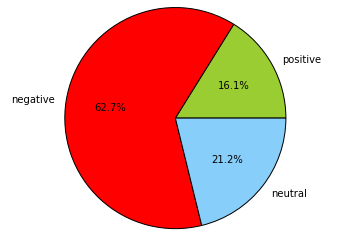

In [2]:
%matplotlib inline
labels = ['positive', 'negative', 'neutral']
sizes = [sum(df['airline_sentiment'] == label) for label in labels]
colors = ['yellowgreen', 'red', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')


## Word frequency distribution

We are interested in the terms frequency distribution since we want to know what frequency we should make the cut-off.
We eliminated stop words and tokenized the tweets using the TweetTokenizer provided by NLTK.


In [3]:
from lib import processing

training_data, testing_data = processing.process_data(df, sample_size=1)

Using a total of 14640 tweets
Training sample size: 13097
Testing sample size: 1543


## Visualizing most used unigrams and bigrams

In [33]:
from collections import defaultdict

freq = defaultdict(int)
unigram_freq = defaultdict(int)
bigram_freq = defaultdict(int)
for tokens, _ in training_data:
    for i, token in enumerate(tokens):
        freq["unigram: {0}".format(token)] += 1
        unigram_freq["{0}".format(token)] += 1
        if i > 0:
            freq["bigram: {0} {1}".format(tokens[i-1], tokens[i])] += 1
            bigram_freq["{0} {1}".format(tokens[i-1], tokens[i])] += 1

print("We have {0} unigrams and bigrams.".format(len(freq))) 
freq_list = sorted([(value, key) for key, value in freq.items()], reverse = True)
unigram_freq_list = sorted([(value, key) for key, value in unigram_freq.items()], reverse = True)
bigram_freq_list = sorted([(value, key) for key, value in bigram_freq.items()], reverse = True)

We have 111877 unigrams and bigrams.


## Most frequent unigrams

In [50]:
for unigram in unigram_freq_list[:20]:
    print("* {0}".format(unigram[1]))

* .
* !
* ?
* ,
* @united
* flight
* @usairways
* @americanair
* @southwestair
* @jetblue
* get
* thanks
* cancelled
* ...
* service
* -
* "
* help
* time
* customer


## Most frequent bigrams

In [35]:
for bigram in bigram_freq_list[:10]:
    print("* {0}".format(bigram[1], 10))

* ! !
* customer service
* cancelled flightled
* ? ?
* flight .
* . thanks
* late flight
* ? !
* cancelled flighted
* thanks !


## Visualizing features frequency distribution

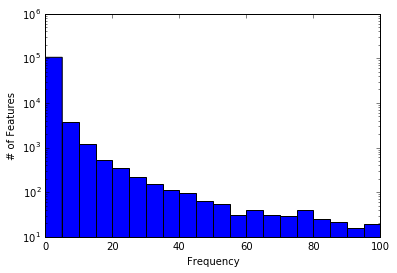

In [44]:
freq_list = pandas.Series(list(freq.values()))
freq_list.plot(kind='hist', bins = 20, range=(0, 100))
plt.ylabel("# of Features")
plt.xlabel("Frequency")
plt.yscale('log', nonposy='clip')

### Viewing number of features based on word min frequency

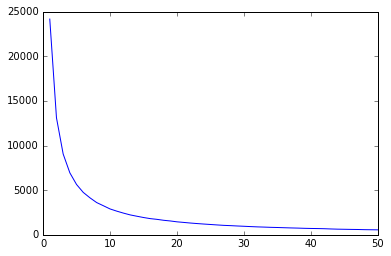

In [45]:
min_freq_range = list(range(1, 51))
features_count = [sum(freq_list > x) for x in min_freq_range]
plt.plot(min_freq_range, features_count)

## Exploring accuracy with various min_freq values

We will use a NaiveBayes classifier, with the default parameters, since it trains faster.

In [48]:
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from lib import classify

min_freq_range = list([5, 10, 15, 20])
accuracy = []
for x in min_freq_range:
    print("Using min frequency of", x)
    sentim_analyzer = SentimentAnalyzer()
    classify.add_features(training_data, sentim_analyzer, min_freq = x)
    train, test = classify.extract_features(training_data, testing_data, sentim_analyzer)
    trainer = {
        'train': NaiveBayesClassifier.train,
    }
    _, evaluation, _ = classify.train_model(train, test, sentim_analyzer, trainer)
    accuracy.append(evaluation['Accuracy'])


Using min frequency of 5
Unigram features 2759
Bigram features:  2875
Training classifier
Evaluating NaiveBayesClassifier results...
Using min frequency of 10
Unigram features 1710
Bigram features:  1187
Training classifier
Evaluating NaiveBayesClassifier results...
Using min frequency of 15
Unigram features 1267
Bigram features:  670
Training classifier
Evaluating NaiveBayesClassifier results...
Using min frequency of 20
Unigram features 1017
Bigram features:  436
Training classifier
Evaluating NaiveBayesClassifier results...


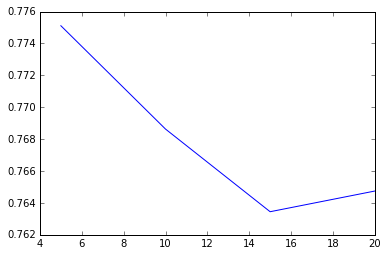

In [49]:
acc = [round(x, 2) for x in accuracy]
plt.plot(min_freq_range, accuracy)

## Conclusion

We will chose to have as features only terms with frequency higher than 10, since it constitues a nice trade-off between accuracy and feature space. 

## Bigrams

We will also use bigrams as features, since improving the feature space will results in better accuracy for our classifiers.